# Code Similarity with Contrastive Learning

## Dependencies

In [ ]:
# for data augmentation
!pip install python-minifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
!pip install pytorch-metric-learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 4.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
from pytorch_metric_learning import losses
# Hugging Face Transformers (CodeBERT etc.)
from transformers import AutoTokenizer, AutoModel
# Libraries for augmenting data
import python_minifier
# Libraries for logging
from tqdm.auto import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

Device: cuda
Tesla T4


## Dataset Access

In [ ]:
from google.colab import userdata
labeled_dataset_url = f"https://drive.google.com/uc?export=download&id={userdata.get('labeledDataset')}"
unlabeled_dataset_url = f"https://drive.google.com/uc?export=download&id={userdata.get('unlabeledDataset')}"

## Dataset and Data Augmentation

In [ ]:
# Code datasets (for labeled and unlabeled code snippets)

def _augment(df, *functions):
    """Calculates data augmentations on a dataframe with labeled source code."""
    augs = []
    _aug = df[df['label'].apply(lambda x: x[-1] == '1')]  # dataframe to augment
    for function in functions:
        aug = _aug.copy()
        aug.loc[:, 'source'] = aug['source'].apply(function)
        augs.append(aug)
    df = pd.concat([df, *augs], ignore_index=True)
    # Sort the dataframe so matching labels are next to eachother.
    df.sort_values(by='label', inplace=True)
    return df


def num_label(labels_map: dict, label: str):
    """Transforms a string label using `label_map: dict`."""
    return labels_map[label] if label[-1] == '1' else -1


def num_labels(labels) -> torch.Tensor:
    """Transforms string labels to numeric labels for the NTXent loss function."""
    labels_map = { label: i for i, label in enumerate(sorted(set(labels))) }
    labels_num = [ num_label(labels_map, label) for label in labels ]
    labels_num = torch.Tensor(labels_num)
    neg_indices = (labels_num == -1).nonzero(as_tuple=True)[0]
    M = max(labels_num)
    labels_num[neg_indices] = torch.arange(M + 1, M + 1 + len(neg_indices))
    return labels_num.to(device)


class LabeledCodeDataset(Dataset):
    def __init__(self, codes, labels):
        self.codes = codes
        self.labels = num_labels(labels)

    def __getitem__(self, idx):
        code = self.codes[idx]
        label = self.labels[idx]
        return code, label

    def __len__(self):
        return len(self.codes)

    @classmethod
    def from_csv_data(cls, path: str, sample_size=0,
        augment=False, augment_functions=None):
        df = pd.read_csv(path)
        print(df.shape)
        if sample_size:
            print('sampling dataframe...')
            df = df.sample(sample_size, ignore_index=True)
            print(df.shape)
        if augment:
            print('augmenting dataframe...')
            df = _augment(df, *augment_functions)
            print(df.shape)
        codes = df['source']
        labels = df['label']
        return cls(codes, labels)


class UnlabeledCodeDataset(Dataset):
    def __init__(self, codes):
        self.codes = codes

    def __getitem__(self, idx):
        code = self.codes[idx]
        return code

    def __len__(self):
        return len(self.codes)

    @classmethod
    def from_csv_data(cls, path: str, sample_size=0):
        df = pd.read_csv(path)
        codes = df['file_content']
        if sample_size:
            print('sampling dataframe...')
            df = df.sample(sample_size, ignore_index=True)
            print(df.shape)
        return cls(codes)

In [ ]:
# Augmentation functions

def minify(code: str) -> str:
    try: return python_minifier.minify(code)
    except Exception as error:
        #print(f'Error while minifying: {error}')  # use a log file for this
        pass
    return code

## Model

In [ ]:
# Model

# TODO: Throw away sequences that are too long instead of truncation.
def embedding_pipeline(tokenizer, transformer, seq_length=512):
    """Create an embedding function with a `tokenizer` and `transformer`."""
    def pipeline(codes, max_length=seq_length):
        inputs = tokenizer(codes, return_tensors='pt', truncation=True,
                           padding='max_length', max_length=max_length)
        inputs.to(device)  # Move inputs tensor to the device
        with torch.device(device):
            outputs = transformer(**inputs)
            return outputs.pooler_output
    return pipeline


class CodeSimilarityModel(nn.Module):
    def __init__(self,
        embedding_pipeline,
        in_feat=768,  # depends on the embedding pipeline
        fc_hidden_size=512,
        mlp_sizes=(256, 128, 64),
        out_feat=16,
        dropout_rate=0.2,
    ):
        super().__init__()
        self.embedding_pipeline = embedding_pipeline
        self.in_feat = in_feat
        # Normalization
        self.layernorm = nn.LayerNorm(self.in_feat)
        # Non linearity
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout_rate)
        # Linear layers before 'projection head'
        self.lin1 = nn.Linear(self.in_feat,
                              fc_hidden_size)
        self.lin2 = nn.Linear(fc_hidden_size,
                              mlp_sizes[0])
        # MLP 'projection head'
        mlp_layers = []
        mlp_layers.append(nn.Linear(mlp_sizes[0], mlp_sizes[1]))
        mlp_layers.extend([self.relu, self.drop])
        mlp_layers.append(nn.Linear(mlp_sizes[1], mlp_sizes[2]))
        mlp_layers.extend([self.relu, self.drop])
        mlp_layers.append(nn.Linear(mlp_sizes[2], out_feat))
        self.mlp = nn.Sequential(*mlp_layers)

    def embeddings(self, codes: tuple[str]) -> torch.Tensor:
        """Embed code snippets using the pipeline."""
        embeddings = self.embedding_pipeline(codes)
        return embeddings

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        with torch.device(device):
            # normalization
            x = self.layernorm(x)  # NOTE: this is unnecesary if using pooled output
            # linear layers

            x = self.lin1(x)
            x = self.relu(x)
            x = self.drop(x)

            x = self.lin2(x)
            x = self.relu(x)
            x = self.drop(x)

            x = self.mlp(x)
            return x

## NTXent Loss Function

In [ ]:
ntxent_loss = losses.NTXentLoss(temperature=0.5)
#ntxent_loss = losses.SelfSupervisedLoss(ntxent_loss)  # for self supervised learning from unlabeled data

## Training

In [ ]:
# Create the dataset
dataset = LabeledCodeDataset.from_csv_data(path=labeled_dataset_url, augment=True, augment_functions=[minify], sample_size=25_000)
#dataset = UnlabeledCodeDataset.from_csv_data(path=unlabeled_dataset_url, sample_size=25_000)

(34806, 3)
sampling dataframe...
(25000, 3)
augmenting dataframe...
(40048, 3)


In [ ]:
# Split the data
tsize = int(0.8 * len(dataset))
vsize = len(dataset) - tsize
training_data, validation_data = random_split(dataset, [tsize, vsize])

In [ ]:
# Create the data loaders
BATCH_SIZE = 20  # NOTE: Bigger batch size generally leads to better results in contrastive learning
SHUFFLE = True  # NOTE: 'shuffle' may be set to 'True' for random sampling
training_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
validation_loader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [ ]:
# Training loop for the NTXEnt loss function
IS_SUPERVISED = True

def compute_loss(batched_data, model, loss_func, is_labeled_data: bool):
    """Computes the loss value for a batch of data.
    This function depends on the loss function passed through `loss_func` which depends on `is_labeled_data`:
    - `is_labeled_data = True` - Any loss may be used with correctly labeled data.
    - `is_labeled_data = False` - `losses.SelfSupervisedLoss` loss should be used.
    """
    if is_labeled_data:
        codes, labels = batched_data
        embeddings = model.embeddings(codes)  # transformer
        embeddings = model(embeddings)  # fc1-fc2, MLP
        loss = loss_func(embeddings, labels)
        return loss
    else:
        BATCH_SIZE = len(batched_data)
        ref_codes = list(batched_data)
        # TODO: This is a PLACEHOLDER, select a random augmentation when more augmentation methods are found/implemented!
        aug_codes = [ minify(code) for code in ref_codes ]
        codes = [*ref_codes, *aug_codes]
        embeddings = model.embeddings(codes)  # transformer
        embeddings = model(embeddings)  # fc1-fc2, MLP
        ref_emb, aug_emb = embeddings[:BATCH_SIZE], embeddings[BATCH_SIZE:]
        loss = loss_func(ref_emb, aug_emb)
        return loss


def train_epoch(
    model: CodeSimilarityModel,
    loader: DataLoader,
    loss_func,
    optimizer,
    epochs: int                  = 0,     # number of epochs so far (for logging),
    writer: SummaryWriter | None = None,  # for logging loss values,
):
    """Trains the model for one epoch."""
    def get_last_loss(n_batches, c_batches, batch, acc_loss):
        if batch % c_batches == c_batches - 1:
            return 0, acc_loss / c_batches
        elif batch == N_BATCHES - 1:
            return 0, acc_loss / (n_batches % c_batches)
        return acc_loss, 0

    def write_loss(writer, epoch, n_batches, batch, last_loss):
        # Log the average loss over the last  batches
        print('',f'Batch: {batch + 1}/{n_batches}, Loss: {last_loss}')  # use a log file for this
        if writer is not None:
            writer.add_scalar("loss/train", last_loss, epochs * n_batches + batch + 1)

    model.train()  # Set the model to training mode
    N_BATCHES = len(loader)  # Number of batches
    C_BATCHES = 50  # Number of batches over which the logged loss is cumulated
    sum_loss = 0  # Loss accumulated per EPOCH
    acc_loss = 0  # Loss accumulated per last 25 batches
    progress_bar = tqdm(range(N_BATCHES))
    for i, data in enumerate(loader):
        optimizer.zero_grad()
        loss = compute_loss(data, model, loss_func, is_labeled_data=IS_SUPERVISED)
        # Adjust the weights
        loss.backward()
        optimizer.step()
        # Increase loss accumulator
        loss_val = loss.item()
        acc_loss += loss_val; sum_loss += loss_val
        # Update the loss accumulator and log the last loss
        progress_bar.update(1)
        acc_loss, last_loss = get_last_loss(N_BATCHES, C_BATCHES, i, acc_loss)
        if last_loss: write_loss(writer, epochs, N_BATCHES, i, last_loss)
    # Return the average loss in the epoch
    avg_loss = sum_loss / N_BATCHES
    return avg_loss


def validate(
    model: CodeSimilarityModel,
    loader: DataLoader,
    loss_func,
):
    """Validates the model for one epoch."""
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        sum_loss = 0
        for data in loader:
            loss = compute_loss(data, model, loss_func, is_labeled_data=IS_SUPERVISED)
            sum_loss += loss.item()
        avg_loss = sum_loss / len(loader)
        return avg_loss


def train(
    model: CodeSimilarityModel,
    dataloaders,
    loss_func,
    optimizer, scheduler,
    epochs: int = 5,
):
    writer = None #SummaryWriter()
    tLosses, vLosses = [], []
    training_loader, validation_loader = dataloaders
    for epoch in range(epochs):
        print(f'EPOCH {epoch + 1}/{epochs}')
        # Train then validate
        avg_tLoss = train_epoch(model, training_loader, loss_func, optimizer, epoch, writer)
        avg_vLoss = validate(model, validation_loader, loss_func)
        # Adjust the LR scheduler
        if scheduler is not None:
            scheduler.step()
        # Log the losses
        print(f"EPOCH {epoch + 1}/{epochs}, AVG loss: {avg_tLoss}, AVG validation loss: {avg_vLoss}")
        tLosses.append(avg_tLoss)
        vLosses.append(avg_vLoss)
    if writer is not None:
        writer.close()
    return tLosses, vLosses

In [ ]:
# Create embedding pipeline, model, tokenizer, and optimizer

"""
other checkpoints
- "microsoft/codebert-base"
- "huggingface/CodeBERTa-small-v1"
"""

pretrained_model="neulab/codebert-python" 
tokenizer = AutoTokenizer.from_pretrained(pretrained_model)
transformer = AutoModel.from_pretrained(pretrained_model).to(device)
transformer.eval()
embedding_pipeline = embedding_pipeline(tokenizer, transformer)
model = CodeSimilarityModel(embedding_pipeline).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [ ]:
# Train the model
epochs = 4
loss_func = ntxent_loss
losses = train(model, (training_loader, validation_loader), loss_func, optimizer, lr_scheduler, epochs)

EPOCH 1/4


  0%|          | 0/1602 [00:00<?, ?it/s]

 Batch: 50/1602, Loss: 1.4753819704055786
 Batch: 100/1602, Loss: 1.5937087726593018
 Batch: 150/1602, Loss: 1.5203195571899415
 Batch: 200/1602, Loss: 1.4102552080154418
 Batch: 250/1602, Loss: 1.5881805658340453
 Batch: 300/1602, Loss: 2.0050727558135986
 Batch: 350/1602, Loss: 1.526360378265381
 Batch: 400/1602, Loss: 1.5416279411315919
 Batch: 450/1602, Loss: 1.7653055238723754
 Batch: 500/1602, Loss: 1.4699258518218994
 Batch: 550/1602, Loss: 1.8849306058883668
 Batch: 600/1602, Loss: 1.5902856588363647
 Batch: 650/1602, Loss: 1.7057515239715577
 Batch: 700/1602, Loss: 1.2905484962463378
 Batch: 750/1602, Loss: 1.6423342180252076
 Batch: 800/1602, Loss: 1.650721502304077
 Batch: 850/1602, Loss: 1.4703876781463623
 Batch: 900/1602, Loss: 1.5909772205352783
 Batch: 950/1602, Loss: 1.9370759963989257
 Batch: 1000/1602, Loss: 1.584716281890869
 Batch: 1050/1602, Loss: 1.6490674209594727
 Batch: 1100/1602, Loss: 1.2990383625030517
 Batch: 1150/1602, Loss: 1.6516365575790406
 Batch: 120

  0%|          | 0/1602 [00:00<?, ?it/s]

 Batch: 50/1602, Loss: 1.3549567222595216
 Batch: 100/1602, Loss: 1.5976257514953613
 Batch: 150/1602, Loss: 1.1725017166137695
 Batch: 200/1602, Loss: 1.7570848417282106
 Batch: 250/1602, Loss: 2.0026543283462526
 Batch: 300/1602, Loss: 1.1154150915145875
 Batch: 350/1602, Loss: 1.6431132364273071
 Batch: 400/1602, Loss: 1.6483309745788575
 Batch: 450/1602, Loss: 1.4094431018829345
 Batch: 500/1602, Loss: 2.117552151679993
 Batch: 550/1602, Loss: 1.780279006958008
 Batch: 600/1602, Loss: 1.7634999179840087
 Batch: 650/1602, Loss: 1.5235039710998535
 Batch: 700/1602, Loss: 1.8352368831634522
 Batch: 750/1602, Loss: 1.7147730779647827
 Batch: 800/1602, Loss: 1.525508050918579
 Batch: 850/1602, Loss: 1.590166645050049
 Batch: 900/1602, Loss: 1.948646945953369
 Batch: 950/1602, Loss: 1.9374954557418824
 Batch: 1000/1602, Loss: 1.7119887065887451
 Batch: 1050/1602, Loss: 1.2332986164093018
 Batch: 1100/1602, Loss: 1.8297982788085938
 Batch: 1150/1602, Loss: 1.5888297986984252
 Batch: 1200/

  0%|          | 0/1602 [00:00<?, ?it/s]

 Batch: 50/1602, Loss: 1.5875871419906615
 Batch: 100/1602, Loss: 1.7694546270370484
 Batch: 150/1602, Loss: 1.409406361579895
 Batch: 200/1602, Loss: 1.7023408842086791
 Batch: 250/1602, Loss: 1.5249450635910033
 Batch: 300/1602, Loss: 2.002179193496704
 Batch: 350/1602, Loss: 1.646096429824829
 Batch: 400/1602, Loss: 1.9453105068206786
 Batch: 450/1602, Loss: 1.9463438129425048
 Batch: 500/1602, Loss: 1.6521005058288574
 Batch: 550/1602, Loss: 1.5829239082336426
 Batch: 600/1602, Loss: 1.8873443412780762
 Batch: 650/1602, Loss: 1.4126148748397827
 Batch: 700/1602, Loss: 1.99792631149292
 Batch: 750/1602, Loss: 1.827587890625
 Batch: 800/1602, Loss: 1.6469278955459594
 Batch: 850/1602, Loss: 1.821724190711975
 Batch: 900/1602, Loss: 1.4718605136871339
 Batch: 950/1602, Loss: 1.592121524810791
 Batch: 1000/1602, Loss: 1.9375625467300415
 Batch: 1050/1602, Loss: 1.6486662101745606
 Batch: 1100/1602, Loss: 1.88463632106781
 Batch: 1150/1602, Loss: 1.8864283180236816
 Batch: 1200/1602, Lo

  0%|          | 0/1602 [00:00<?, ?it/s]

 Batch: 50/1602, Loss: 1.4121205282211304
 Batch: 100/1602, Loss: 1.7722966146469117
 Batch: 150/1602, Loss: 1.8810738706588745
 Batch: 200/1602, Loss: 1.7087460136413575
 Batch: 250/1602, Loss: 1.5923957443237304
 Batch: 300/1602, Loss: 1.829098982810974
 Batch: 350/1602, Loss: 1.820530662536621
 Batch: 400/1602, Loss: 1.3527455139160156
 Batch: 450/1602, Loss: 1.5277396631240845
 Batch: 500/1602, Loss: 1.8759089279174805
 Batch: 550/1602, Loss: 1.5313961601257324
 Batch: 600/1602, Loss: 1.6557240056991578
 Batch: 650/1602, Loss: 1.6485271978378295
 Batch: 700/1602, Loss: 1.6441902112960816
 Batch: 750/1602, Loss: 2.062365493774414
 Batch: 800/1602, Loss: 1.647779679298401
 Batch: 850/1602, Loss: 1.7626540231704713
 Batch: 900/1602, Loss: 1.6479469537734985
 Batch: 950/1602, Loss: 1.5940438604354858
 Batch: 1000/1602, Loss: 1.5875860166549682
 Batch: 1050/1602, Loss: 1.8960465335845946
 Batch: 1100/1602, Loss: 1.357122268676758
 Batch: 1150/1602, Loss: 1.3553007078170776
 Batch: 1200/

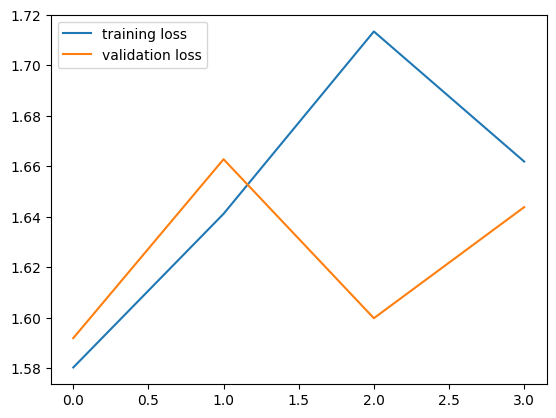

In [ ]:
plt.plot(losses[0])
plt.plot(losses[1])
plt.legend(['training loss', 'validation loss'])
plt.show()

## Notes

### Training results with different parameters

| Checkpoint |`T`| Model Structure | Epochs | Training Loss | Validation Loss |
| ---------- | - | --------------- | ------ | ------------- | --------------- |
| CodeBERTa Small v1 | 0.07 | TFM → mean pool → MLP w/ batchnorm | - | ~1.6 | - |
| CodeBERTa Small v1 | 0.07 | TFM → lin1 → lin2 → MLP w/ batchnorm → max pool | - | ~1.4 | - |
| CodeBERTa Small v1 | 0.50 | (frozen) TFM's pooler output → layernorm → lin1 → lin2 → MLP  | 6 |  ~1.5 | ~1.35 |

`T` is the temperature hyperparameter of the NTXent loss function.

### Data TODOs
- ❎ - Throw away code snippets that are too long
- ❎ - A lot of codes snippets mined from github can't be minified, filter unlabeled code dataset!
- ❎ - Pre calculate data augmentations

### Model TODOs
- ❎ - Try training with transformer's `pooler_output`